В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook. Эти задания проверят вручную, и вы получите комментарии к составленным запросам. 

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. Вспомните инструкцию из [урока про представление результатов](https://practicum.yandex.ru/learn/data-analyst-plus/courses/96ccbf7a-b65d-4f51-b5f3-18360ad1e301/sprints/6116/topics/27f7c9a7-a474-4a82-8392-b3f069b26f69/lessons/e12d84bb-ffa8-490c-8bde-0935d86ceccb/). Пример кода для подключения к базе и выгрузки результатов вы найдёте и в этой тетрадке. 

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм. 

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date):: date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY 1
ORDER BY 2 DESC
'''
sample_df_1 = pd.read_sql_query(query, con=engine)
sample_df_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


1. **Больше всего было просмотров в сентябре месяце - 452 млн.**
2. **Меньше всего просмотров было в августе -670 тысяч. Это обусловлено тем, что за июль месяц нам представлены не полные данные (не за каждый день).**
3. **Резкий скачек с сентября месяца может быть обусловлен началом учебного периода и выхода всех из отпусков.**

# Задание 2

Выведите список имён самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name |
| ------------ |
| 1800 INFORMATION |
| Adam Bellaire |
| Adam Davis |
| ... |

In [7]:
# напишите запрос
query_2 = '''
WITH bob AS
(SELECT  u.display_name AS display_name,
        COUNT(p.id) AS posts
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id = u.id
WHERE (post_type_id IN (SELECT id
                       FROM stackoverflow.post_types
                       WHERE type = 'Answer')) AND
   p.creation_date BETWEEN u.creation_date AND u.creation_date + INTERVAL'1 month'
GROUP BY 1)
SELECT display_name
FROM bob
WHERE posts > 100
ORDER BY display_name
LIMIT 10
'''
sample_df_2 = pd.read_sql_query(query_2, con=engine)
sample_df_2
# выполните запрос

,display_name
0,1800 INFORMATION
1,Adam Bellaire
2,Adam Davis
3,Adam Liss
4,Alan
5,Amy B
6,Ben Hoffstein
7,Brian
8,Cade Roux
9,CesarB


# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 182984 |
| ... | ... |

In [8]:
# напишите запрос
query_3 = '''
WITH bob AS
(SELECT u.id AS name
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
WHERE u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'
AND p.creation_date:: date BETWEEN '2008-12-01' AND '2008-12-31')

SELECT DATE_TRUNC('month', p.creation_date):: date AS month,
       count(p.user_id)
FROM stackoverflow.posts p
WHERE p.user_id IN (SELECT name
                       FROM bob) 
Group by 1
ORDER BY 1 DESC
'''
sample_df_3 = pd.read_sql_query(query_3, con=engine)
sample_df_3
# выполните запрос

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

1. **Стоит обратить внимание на то, что имеются данные за август месяц. Скорее всего это связано с ошибкой при формировании данных.**
2. **Скорее всего, проблема заключается в том, что в данных имеется ошибка, в части регистрации пользователей, то есть, есть пользователи, которые зарегистрированы в сентябре, но при этом писали посты в августе.**

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query_4 = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
'''
sample_df_4 = pd.read_sql_query(query_4, con=engine)
sample_df_4
# выполните запрос

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.8076923076923077 |
| 234     | 5.3043478260869565 |
| ...     | ... |

In [10]:
# напишите запрос
query_5 = '''
WITH rt AS
(SELECT p.user_id AS user_id,
        p.creation_date::date AS aug,
        COUNT(p.id) AS total
FROM stackoverflow.posts p
WHERE p.user_id IN (SELECT p.user_id
                    FROM stackoverflow.posts p
                    WHERE p.creation_date::date
                    BETWEEN '2008-08-01' AND '2008-08-31'
                    GROUP BY p.user_id
                    HAVING COUNT(*) >120)
GROUP BY aug, user_id)
SELECT user_id,
       AVG(total)
FROM rt
WHERE  aug BETWEEN '2008-08-01' AND '2008-08-31'
GROUP BY user_id
ORDER BY avg
'''
sample_df_5 = pd.read_sql_query(query_5, con=engine)
sample_df_5
# выполните запрос

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query_6 = '''
WITH test AS
(SELECT p.user_id AS user_id,
       COUNT(DISTINCT p.creation_date:: date) AS creation_date
FROM stackoverflow.posts p
WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY 1)
SELECT ROUND(AVG(creation_date))
FROM test
'''
sample_df_6 = pd.read_sql_query(query_6, con=engine)
sample_df_6
# выполните запрос

,round
0,2.0


**Из 7 дней, в среднем у пользователей было 2 активных дня, что составляет 28,6 % от общего количества дней. Такая активность может быть обусловлена тем, что пользователей предпочитают уделять время ресурсу в выходные дни.**

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | NULL |
| 1       | 2008-07-31 23:55:38 | NULL |
| 1       | 2008-07-31 23:56:41 | Июль |
| 1       | 2008-08-04 02:45:08 | Июль |
| 1       | 2008-08-04 04:31:03 | Июль |
| 1       | 2008-08-04 08:04:42 | Август |
| ... | ... | ... |

In [12]:
# напишите запрос
query_7 = '''
WITH test AS
(SELECT p.user_id AS user_id,
       p.creation_date AS creation_date,
       LAG(DATE_TRUNC('month', p.creation_date):: date ,2, NULL) OVER (PARTITION BY p.user_id) AS previous
FROM stackoverflow.posts p
GROUP BY 1, 2)
SELECT user_id,
       creation_date,
CASE
  previous  WHEN previous THEN  to_char(to_timestamp(date_part('month', previous):: text, 'MM'), 'Month')
END
FROM test
'''
sample_df_7 = pd.read_sql_query(query_7, con=engine)
sample_df_7
# выполните запрос

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --------- | ------------ | --------- | ---------------- | -------------- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 | 
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
query_8 = '''
WITH profiles AS
  (SELECT DISTINCT user_id,
          MIN(DATE_TRUNC('month', creation_date):: date) AS creation_date,
      COUNT(user_id) OVER(PARTITION BY MIN(DATE_TRUNC('month', creation_date):: date)) AS cohort_users_cnt
   FROM stackoverflow.posts
   GROUP BY 1),
sessions AS 
(SELECT user_id,
        DATE_TRUNC('month', creation_date):: date AS session_date
FROM stackoverflow.posts
GROUP BY 1,
         2)
SELECT p.creation_date cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profiles p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4; 
'''
sample_df_8 = pd.read_sql_query(query_8, con=engine)
sample_df_8
# выполните запрос

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


In [14]:
# постройте тепловую карту Retention Rate
sample_df_8_pivot = pd.pivot_table(sample_df_8,
                                   index ='cohort_dt',
                                   columns = 'session_date',
                                    values = 'retention_rate')
sample_df_8_pivot

session_date,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01
cohort_dt,,,,,,
2008-07-01,100.0,66.67,33.33,66.67,33.33,66.67
2008-08-01,NaN,100.00,73.04,59.27,48.81,41.56
2008-09-01,NaN,NaN,100.00,53.82,38.63,32.56
2008-10-01,NaN,NaN,NaN,100.00,45.19,33.65
2008-11-01,NaN,NaN,NaN,NaN,100.00,40.36
2008-12-01,NaN,NaN,NaN,NaN,NaN,100.00


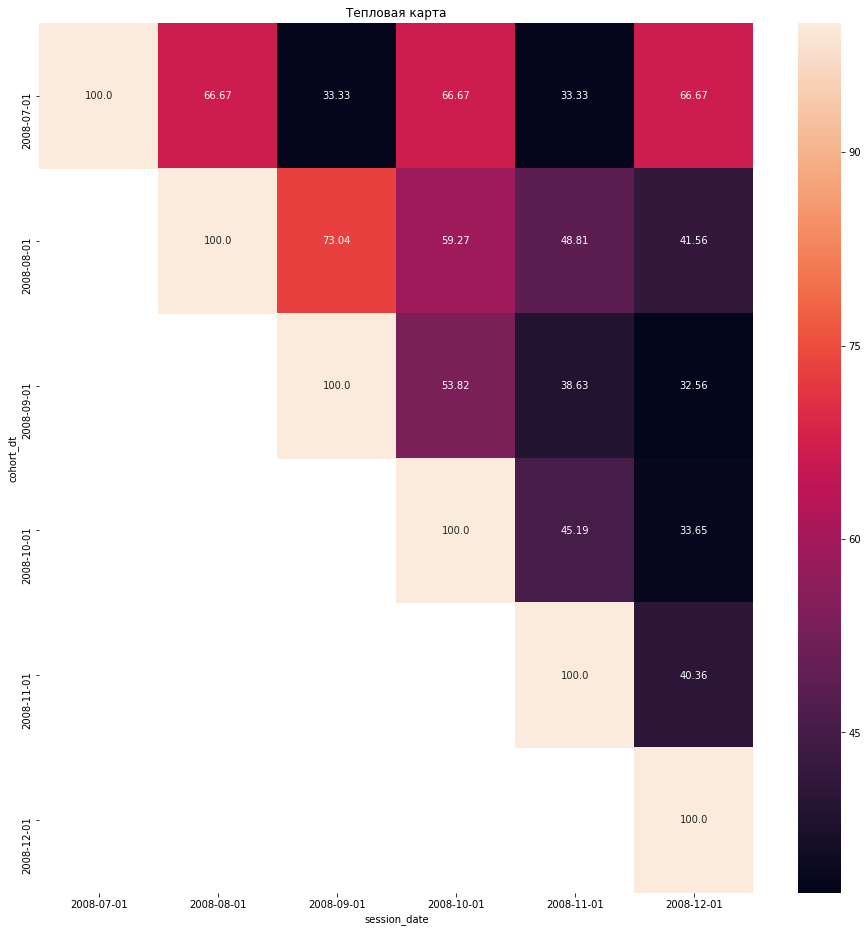

In [15]:
plt.figure(figsize=(16, 16))
sns.heatmap(sample_df_8_pivot,
            annot=True,
            fmt ='')
plt.title('Тепловая карта')
plt.show()

1. **Мы наблюдаем аномалию для когорты от 2008.07.01 по причине значительного увеличения Retention Rate в рассматриваемом периоде.**
2. **Я думаю, что причиной возникновения данной аномалии является факт того, что есть пользователи, которые были зарегистрированы позже, чем написали пост**

# Задание 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | NULL |
| 10 | 63102 | -11 |
| ... | ... | ... |

In [16]:
# напишите запрос
query_9 = '''
WITH test AS 
(SELECT DATE_TRUNC('month', creation_date):: date AS creation_date,
       COUNT(id) AS count_post
   FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY 1),
test_2 AS
(SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
       count_post,
       count_post - LAG(count_post,1, NULL) OVER (ORDER BY creation_date) AS previous
FROM test)
select creation_month,
       count_post,
       previous*100 / LAG(count_post, 1, NULL) OVER (ORDER BY creation_month)
From test_2
'''
sample_df_9 = pd.read_sql_query(query_9, con=engine)
sample_df_9
# выполните запрос

,creation_month,count_post,?column?
0,9.0,70371,NaN
1,10.0,63102,-10.0
2,11.0,46975,-25.0
3,12.0,44592,-5.0


In [17]:
# постройте круговую диаграмму с количеством постов по месяцам
sample_df_9_pivot = pd.pivot_table(sample_df_9,
                                   index ='creation_month',
                                    values = 'count_post')
sample_df_9_pivot

,count_post
creation_month,
9.0,70371
10.0,63102
11.0,46975
12.0,44592


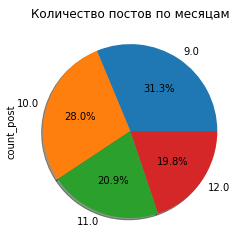

In [18]:
sample_df_9_pivot.plot.pie(y='count_post', title="Количество постов по месяцам", 
                           legend=False, shadow=True, startangle=0, autopct='%1.1f%%',radius=1)
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [19]:
# напишите запрос
query_10 = '''
WITH test AS
(SELECT user_id,
      COUNT(id) AS count_post
FROM stackoverflow.posts
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1),
test_2 AS
(SELECT user_id,
       COUNT(id) AS count_post,
       creation_date,
       EXTRACT(WEEK FROM creation_date) AS week_creation
   FROM stackoverflow.posts
WHERE (creation_date BETWEEN '2008-10-01' AND '2008-10-31') AND user_id in (SELECT user_id
                                                                            FROM test)
GROUP BY 1,3
ORDER BY 3 )
SELECT DISTINCT week_creation,
       MAX(creation_date) OVER(ORDER BY week_creation) AS creation_date
FROM test_2
ORDER BY 1
'''
sample_df_10 = pd.read_sql_query(query_10, con=engine)
sample_df_10

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-30 22:50:00
